In [10]:
import os
import numpy as np
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体为微软雅黑
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

log_path = (
    "./runs/Apr20_00-33-49_dbcloud"  # Modify this to your TensorBoard log directory
)

figDir = "./figs"

# Initialize an event accumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()  # Loads all the data from the directory

# List all tags in the log file
print(event_acc.Tags()["scalars"])

['aspect_accuracy', 'score_rmse', 'batch loss', 'training loss']


In [2]:
def get_item(tag):
    # E.g. get all scalar data under 'train_loss' tag
    scalar_data = event_acc.Scalars(tag)
    steps = []
    values = []
    for scalar in scalar_data:
        steps.append(scalar.step)
        values.append(scalar.value)
    return steps, values

Text(0, 0.5, 'accuracy')

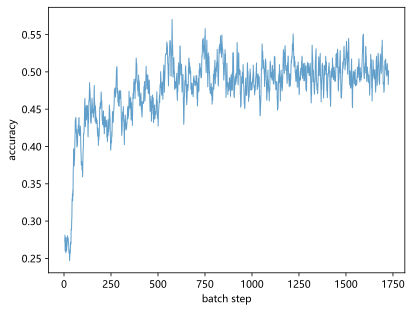

In [3]:
_, values = get_item("aspect_accuracy")
values = values[: 3 * 576]
steps = np.arange(len(values))

window_size = 5
smoothed_values = pd.Series(values).rolling(window_size).mean()

plt.plot(steps, smoothed_values, alpha=0.7, linewidth=1)
plt.xlabel("batch step")
plt.ylabel("accuracy")

Text(0, 0.5, 'score RMSE')

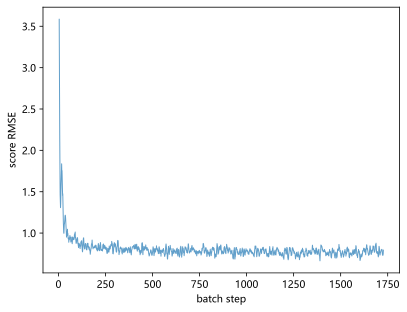

In [4]:
_, values = get_item("score_rmse")
values = values[: 3 * 576]
steps = np.arange(len(values))

window_size = 5
smoothed_values = pd.Series(values).rolling(window_size).mean()

plt.plot(steps, smoothed_values, alpha=0.7, linewidth=1)
plt.xlabel("batch step")
plt.ylabel("score RMSE")

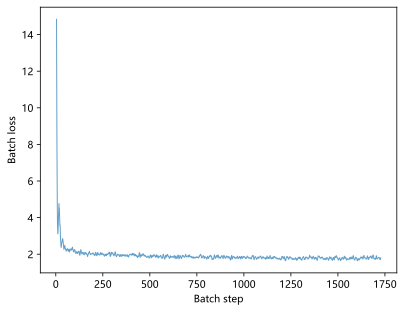

In [5]:
_, values = get_item("batch loss")
values = values[: 3 * 576]
window_size = 5
smoothed_values = pd.Series(values).rolling(window_size).mean()
steps = np.arange(len(values))
plt.plot(steps, smoothed_values, alpha=0.7, linewidth=1)
plt.xlabel("Batch step")
plt.ylabel("Batch loss")

plt.savefig(os.path.join(figDir, "loss.svg"))

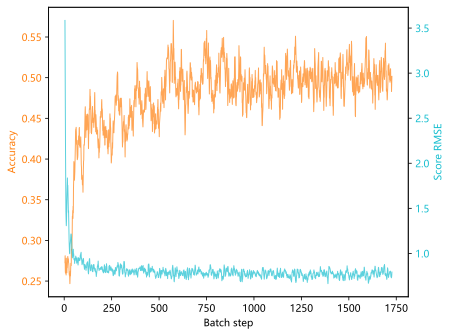

In [6]:
# 获取数据
_, values_accuracy = get_item("aspect_accuracy")
values_accuracy = values_accuracy[: 3 * 576]
steps_accuracy = np.arange(len(values_accuracy))

_, values_rmse = get_item("score_rmse")
values_rmse = values_rmse[: 3 * 576]
steps_rmse = np.arange(len(values_rmse))

# 计算移动平均以光滑数据
window_size = 5
smoothed_values_accuracy = pd.Series(values_accuracy).rolling(window_size).mean()
smoothed_values_rmse = pd.Series(values_rmse).rolling(window_size).mean()

# 创建图表
fig, ax1 = plt.subplots()

# 绘制 accuracy
color = "tab:orange"
ax1.set_xlabel("Batch step")
ax1.set_ylabel("Accuracy", color=color)
ax1.plot(steps_accuracy, smoothed_values_accuracy, color=color, alpha=0.7, linewidth=1)
ax1.tick_params(axis="y", labelcolor=color)

# 创建第二个坐标轴
ax2 = ax1.twinx()
color = "tab:cyan"
ax2.set_ylabel("Score RMSE", color=color)
ax2.plot(steps_rmse, smoothed_values_rmse, color=color, alpha=0.7, linewidth=1)
ax2.tick_params(axis="y", labelcolor=color)

# save figure
plt.savefig(os.path.join(figDir, "accuracy_rmse.svg"))

# 显示图表
fig.tight_layout()

plt.show()

In [1]:
from main import (
    BertForFineGrainedSentimentClassification,
    tokenizer,
    evaluation,
    train_loader,
    test_loader,
    train_set,
    test_set,
    device,
    BertConfig,
    useModel,
    cacheDir,
    torch,
)

import os
import numpy as np
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")

figDir = "./figs"


In [2]:
config = BertConfig.from_pretrained(useModel)

model = BertForFineGrainedSentimentClassification(
    num_classes_per_aspect=4,
    num_aspects=18,
    config=config,
).to(device)
# model.load_state_dict(torch.load(os.path.join(cacheDir, "model_1.pth")))

In [3]:
model.scorer[2].weight.shape

torch.Size([1, 768])

In [4]:
tick = 0

for idx, item in enumerate(test_set):
    inputs = {
        key: val.unsqueeze(0).to(device) for key, val in item.items() if key != "labels"
    }
    labels = item["labels"].unsqueeze(0).to(device)

    input_ids, attention_mask = inputs["input_ids"], inputs["attention_mask"]
    # skip if too short
    if torch.sum(input_ids != tokenizer.pad_token_id) < 200:
        continue

    print(idx, torch.sum(attention_mask))

    # decode input_ids
    sentence = tokenizer.decode(input_ids.squeeze(0).tolist())
    print(sentence)

    outputs, _ = model(inputs)
    print(outputs.shape)

    tick += 1

    if tick == 3:
        break

0 tensor(211, device='cuda:0')
[CLS] 和 老 公 的 朋 友 们 聚 餐 ， 选 择 了 这 家 烧 肉 屋 ， 据 说 人 气 很 旺 ， 于 是 定 座 的 ， 我 们 坐 在 楼 上 ， 阁 楼 感 觉 有 点 空 气 不 流 通 ， 我 这 个 孕 妇 貌 似 不 适 合 油 烟 味 大 的 地 方 ， 虽 然 已 经 过 了 孕 吐 期 ， 但 一 开 始 不 太 习 惯 ， 发 现 窗 没 有 可 以 开 的 ， 都 是 固 定 的 有 点 小 失 望 ， 后 来 慢 慢 就 习 惯 了 ， 开 始 点 了 几 个 甜 筒 ， 很 大 一 个 ， 味 道 还 凑 合 ， 后 来 大 家 点 了 很 多 肉 ， 其 中 有 一 个 肉 味 道 很 好 ， 但 是 只 顾 着 吃 也 忘 记 叫 啥 了 ， 点 了 两 份 石 锅 饭 也 全 干 掉 了 ， 朋 友 的 老 婆 点 了 冷 面 ， 第 一 次 吃 这 样 的 ， 感 觉 不 错 啊 ！ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

AttributeError: 'BertForFineGrainedSentimentClassification' object has no attribute 'Wa'

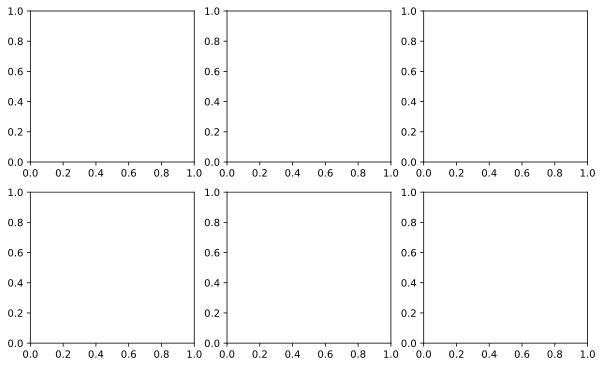

In [5]:
def plot_weight():
    # 2 x 3
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    # plot value distribution of Wa
    axs[0, 0].hist(model.Wa.detach().cpu().numpy().flatten(), bins=100)
    # w
    axs[0, 1].hist(model.w.detach().cpu().numpy().flatten(), bins=100)
    # Wp
    axs[0, 2].hist(model.Wp.detach().cpu().numpy().flatten(), bins=100)
    # Wq
    axs[1, 0].hist(model.Wq.detach().cpu().numpy().flatten(), bins=100)
    # bp
    axs[1, 1].hist(model.bq.detach().cpu().numpy().flatten(), bins=100)
    # save figure
    plt.savefig(os.path.join(figDir, "weight_1.svg"))


plot_weight()

torch.Size([1, 768, 512])
torch.Size([1, 18, 768, 512])
torch.Size([1, 18, 512, 1])
[CLS] 看 到 大 众 点 评 网 的 推 荐 来 试 试 看 ， 在 意 大 利 餐 厅 吃 泰 国 菜 虽 然 说 是 创 意 泰 菜 ， 也 只 是 摆 盘 更 多 变 、 时 尚 ， 味 道 倒 是 一 点 也 不 减 在 地 风 味 。 其 中 像 是 咖 哩 鸭 肉 、 凉 拌 花 枝 、 炸 虾 卷 、 凉 拌 柚 子 等 ， 都 是 一 等 一 的 佳 肴 。 餐 厅 装 潢 不 失 其 创 意 品 牌 的 风 格 ， 结 合 了 意 大 利 家 具 、 西 欧 室 内 布 置 再 加 上 一 点 点 意 式 风 情 ， 嘴 里 吃 的 却 是 地 道 的 泰 国 菜 ， 结 合 不 同 的 异 国 元 素 ， 给 予 顾 客 相 当 新 颖 的 感 官 享 受 。 我 们 三 人 选 择 推 荐 的 泰 式 炸 鱼 ， 满 满 一 大 盘 值 回 票 价 ！ 其 他 西 餐 性 价 比 就 一 般 了 ， 80 泰 铢 的 菠 萝 汁 只 有 小 小 一 杯 ， pizza 皮 薄 但 馅 少 ！ 总 体 而 言 比 较 适 合 观 光 客 来 品 尝 一 下 吧 ！ ( ( ( o ( * ﾟ▽ﾟ * ) o ) ) ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

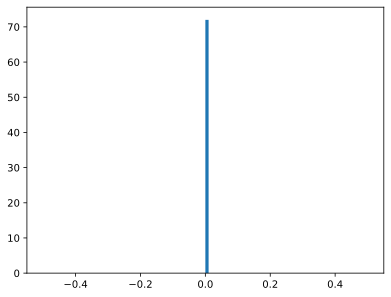

In [ ]:
def plot_attention(useSample=test_set[3]):
    inputs = {
        key: val.unsqueeze(0).to(device)
        for key, val in useSample.items()
        if key != "labels"
    }
    labels = useSample["labels"].unsqueeze(0).to(device)

    input_ids, attention_mask = inputs["input_ids"], inputs["attention_mask"]

    _ = model(inputs)

    print(model.process_dict["sequence_output"].shape)
    # print(model.process_dict["sequence_output"])

    # plot value distribution of Wa
    plt.hist(model.bq.detach().cpu().numpy().flatten(), bins=100)
    # print(model.Wa)

    print(model.process_dict["Ma"].shape)
    # print(model.process_dict["Ma"])

    print(model.process_dict["wMa"].shape)
    # print(model.process_dict["wMa"][:, 0, :])
    # plot value distribution of wMa
    # plt.hist(model.process_dict["wMa"].detach().cpu().numpy().flatten(), bins=100)

    # print(model.process_dict["alpha"][:, 0, :])

    sentence = tokenizer.decode(input_ids.squeeze(0).tolist())
    print(sentence)


plot_attention()

In [ ]:
model.Wq

Parameter containing:
tensor([[[-8.9643e-04, -8.4338e-03, -2.1007e-03,  ..., -1.8813e-02,
           6.3090e-03, -1.0965e-02],
         [ 3.9620e-03,  2.3728e-02,  6.8130e-04,  ...,  2.2211e-03,
          -1.7157e-02, -3.6025e-03],
         [-1.4811e-02,  9.1528e-03,  7.6860e-03,  ..., -7.0786e-03,
           1.2778e-02, -2.5212e-03],
         [ 2.1950e-04,  2.4804e-03, -2.7563e-03,  ...,  7.4484e-03,
           5.8301e-03,  2.5287e-02]],

        [[-2.2357e-02, -5.0270e-03, -1.4673e-02,  ...,  1.3673e-02,
           4.4543e-04,  1.3175e-02],
         [ 9.4659e-03, -1.5924e-02,  1.1374e-02,  ..., -4.4115e-03,
          -5.2016e-03, -1.9268e-02],
         [ 6.9463e-03, -1.4015e-02, -1.5267e-02,  ..., -6.3365e-03,
           7.5845e-03,  6.0282e-03],
         [ 7.5255e-03,  1.9871e-03,  4.7019e-05,  ...,  1.1811e-02,
           7.2180e-03, -2.1409e-02]],

        [[-3.9826e-03,  2.3430e-02, -1.0842e-02,  ...,  1.9376e-03,
          -5.0667e-03,  2.2384e-03],
         [-4.4871e-03, -3.399

In [ ]:
# train_metircs = evaluation(model, train_loader)
# train_metircs

In [ ]:
# test_metircs = evaluation(model, test_loader, iftest=True)
# test_metircs